# How Shazam Works - An explanation using Python

Have you ever wondered how Shazam works? How it is able to so quickly and efficiently identify songs playing, even on poor mobile phone microphones in crowded locations? Surely with all the imperfections in the recording, you wouldn't be able to match snippets of recordings like you might when searching for lyrics? Fortunately, Shazam is not as magical as it first may seem, requiring only a preliminary understanding of frequency domain analysis.

This article will cover developing a simple prototype of Shazam in Python - building a database of the Billboard Hot 100 (of January 2021), and being able to match iPhone recordings to the original songs, even in the presence of background noise and compression.

> Note: While this article covers the basics of Fourier analysis, it does not attempt to be entirely mathematically rigourous - but it conveys enough to understand Shazam. Similarly, this won't be a Python tutorial - but any particularly interesting functions or tricks will be explained.

# Getting Set Up
For this article, I'm using Python3 along with Numpy, SciPy, Matplotlib and a couple of other libraries.

The most important things you're going to need are songs to form your database. I happen to have the files for the Billboard Hottest 100, but any set of songs will do. These files, typically MP3's, are most easily worked with in Python when converted into .wav files. There are variety of ways to convert a folder of mp3's to single channel wav files, but I used the following command using `ripgrep` and `ffmpeg`:

```
ls *.mp3 | rg -o "(.*?)\.mp3" -r '$1' | xargs -n 1 -I '{}' -d '\n' ffmpeg -i '{}.mp3' -ac 1 'converted/{}.wav
```

# Characterising Sound

The first step in building Shazam is to create *fingerprints* of tracks - identfying some kind of feature of a song that makes it distinct from other songs. Additionally, this kind of fingerpint should be immune to corruption: much like the human ear's ability to filter out background noise and compression artifacts, the fingerprint should be recognisable even in the poorest of conditions. 

> While Shazam today uses smart phone recordings transmitted over the internet, Shazam launched 2002 and used phone calls with the most horrific quality - and still worked!

The key to fingerprinting is to look at music in terms of the frequencies of sound that combine to make it up, rather than as a string of notes or lyrics over time. This practice is called *Fourier analysis*, a field of mathematics pioneered in the 18th and 19th centuries, particularly by Joseph Fourier. The primary technique is the Fourier transform, which transforms a signal, such as a song, into the constituent frequencies that comprise it.





The simplest conception of what Fourier transform does is to think of the spectrogram that shows up on your hifi or on Youtube videos of music songs.

For example, here is a view of a sound signal when viewed over time:

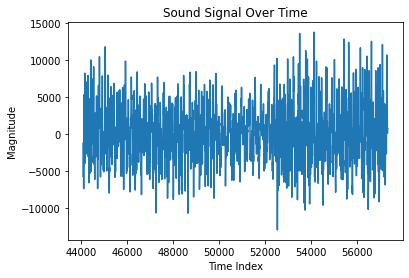

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft, signal
import scipy
from scipy.io.wavfile import read

# Read the input WAV files
# Fs is the sampling frequency of the file
Fs, song = read("data/001. 24kgoldn - Mood (feat. iann dior).wav")

time_to_plot = np.arange(Fs * 1, Fs * 1.3, dtype=int)
plt.plot(time_to_plot, song[time_to_plot])
plt.title("Sound Signal Over Time")
plt.xlabel("Time Index")
plt.ylabel("Magnitude");

This signal like this suffers from several problems: there is a lot of high frequency noise (common due to compression and microphone interference) which makes idenfying important peaks or other features difficult; and any background noise will be indistinguishable from the main song.

The Fourier Transform counters most of these difficulties. The Fourier transform maps the relative 'amount' of a specific frequency compared to the other ones. Let's start with a contrived example, courtesy of the SciPy documentation.

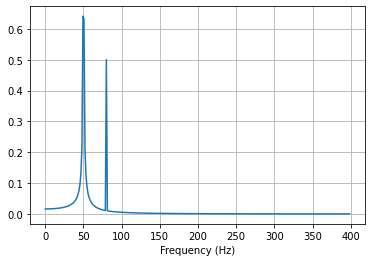

In [3]:
from scipy.fft import fft, fftfreq
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)

# Create a signal comprised of a 50 Hz wave and an 80 Hz wave
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frequency (Hz)")
plt.show()

This example clearly illustrates the spikes at 50 and 80 Hz, demonstrating that there is a large amount of signal 'power' at these two frequencies.

The Fourier transform is extremely powerful when combatting noise and other distortions. See a modified example below: 

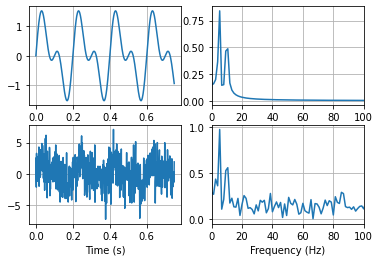

In [4]:
# Generate a similar pair of sin waves as before, but slowed down for easier illustration
y = np.sin(5.0 * 2.0*np.pi*x) + 0.75*np.sin(10.0 * 2.0*np.pi*x)

# Add Gaussian Noise to one of the signals
y_corrupted = y + np.random.normal(0, 2, len(y))

# Plot and perform the same FFT as before

plt.subplot(2, 2, 1)
plt.plot(x, y)
plt.xlabel("Time (s)")
plt.grid()
plt.subplot(2, 2, 3)
plt.plot(x, y_corrupted)
plt.xlabel("Time (s)")
plt.grid()

yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.subplot(2, 2, 2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim(0, 100)
plt.xlabel("Frequency (Hz)")
plt.grid()

yf = fft(y_corrupted)
xf = fftfreq(N, T)[:N//2]
plt.subplot(2, 2, 4)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim(0, 100)
plt.xlabel("Frequency (Hz)")
plt.grid()

When viewed in time (on the left), the distorted signal is mostly unrecognisable. Sure, the general shape has not been completely lost, but the original peaks and troughs have been completely overruled. However, when viewed in the *frequency domain* (after performing the Fourier transform), the two peaks for the 5 and 10 Hz signals are still present, even with the large amount of noise.

We can apply this exact same technique to our song from before, 24kgolden's Mood. 

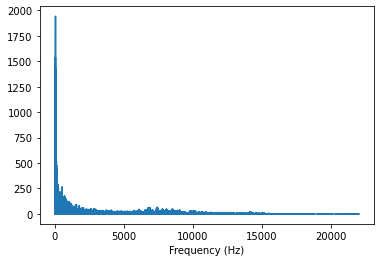

In [5]:
N = len(song)
fft = scipy.fft.fft(song)
transform_y = 2.0 / N * np.abs(fft[0:N//2])
transform_x = scipy.fft.fftfreq(N, 1 / Fs)[:N//2]
plt.plot(transform_x, transform_y)
plt.xlabel("Frequency (Hz)");

This spectrum is a bit harder to decipher at first glance, especially when viewing the entire frequency range (the Fourier transform can determine frequencies from 0 to the Nyquist Frequency, half the sampling rate). However, when viewing only from 0 to 2000 Hz, it becomes clear that there are several frequencies of importance.

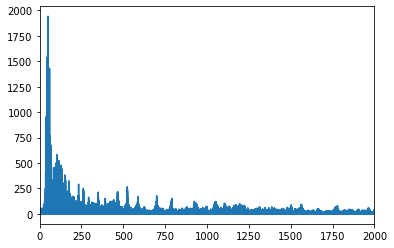

In [6]:
plt.plot(transform_x, transform_y)
plt.xlim(0, 2000);

We can now use the standard SciPy peak finding methods to find peaks in the spectrum. However, the very noisy makeup of the spectrum means that there are too many peaks to identify regions of actual interest that will be useful in developing fingerprints of the song. 

Fortunately, SciPy allows us to constrain our search for only the most important peaks. From my investigations, music tends to have it's strongest peaks in the lower frequency range (< 500Hz), so a peak finding method that only considers the most *prominent* peaks (peaks with the shallowest 'valley' on either side) will have it's peaks concentrated in the bass frequencies. By specifying a minimum distance of 500 samples and then finding the ten most prominent peaks after that allows finding representative peaks of the sample.

Contrast below the mess of peaks identified by default, with a more constrained version:


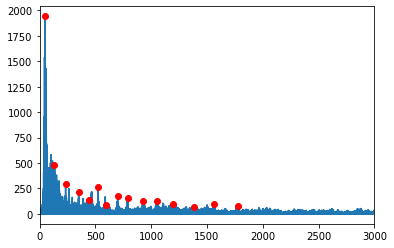

In [7]:
all_peaks, props = signal.find_peaks(transform_y)

peaks, props = signal.find_peaks(transform_y, prominence=0, distance=10000)
n_peaks = 15
# Get the n_peaks largest peaks from the prominences
largest_peaks_indices = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
largest_peaks = peaks[largest_peaks_indices]
plt.plot(transform_x, transform_y, label="Spectrum")
plt.scatter(transform_x[largest_peaks], transform_y[largest_peaks], color="r", zorder=10, label="Constrained Peaks")
plt.xlim(0, 3000)

plt.show()


These peak frequencies are an ideal way to characterise the sound being analysed. 

This method currently analyses the spectrum of the entire song as a whole. However, songs tend to change their sound throughout - the chorus and final verse might have completely different spectrums. The short snippet being recorded on a user's phone is unlikely to match the frequency content of the entire song.

To get around this, we can perform the Fourier Transform on short snippets of the song, such as half a second in length, and then have an entire set of key frequencies over time. This will allow us to match the fingerprints of the user's recording to any point of the song.

This can easily be acheived by using the SciPy implementation of the Short Time Fourier Transform, which applies the Fourier transform in windows (with slight overlap between each one). 

In [19]:
# Some parameters
window_length_seconds = 3
window_length_samples = int(window_length_seconds * Fs)
window_length_samples += window_length_samples % 2

# Perform a short time fourier transform
# frequencies and times are references for plotting/analysis later
# the stft is a NxM matrix
frequencies, times, stft = signal.stft(
    song, Fs, nperseg=window_length_samples,
    nfft=window_length_samples, return_onesided=True
)

stft.shape

(66151, 95)

We can then perform the same peak finding as before, and plot the results as a graph of time across the X axis and the frequency of the peak on the Y axis. This forms a *constellation* of points which characterise the song.

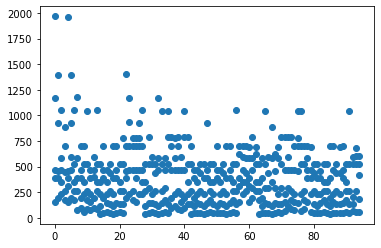

In [20]:
constellation_map = []

for time_idx, window in enumerate(stft.T):
    # Spectrum is by default complex. 
    # We want real values only
    spectrum = abs(window)
    # Find peaks - these correspond to interesting features
    # Note the distance - want an even spread across the spectrum
    peaks, props = signal.find_peaks(spectrum, prominence=0, distance=200)

    # Only want the most prominent peaks
    # With a maximum of 5 per time slice
    n_peaks = 5
    # Get the n_peaks largest peaks from the prominences
    # This is an argpartition
    # Useful explanation: https://kanoki.org/2020/01/14/find-k-smallest-and-largest-values-and-its-indices-in-a-numpy-array/
    largest_peaks = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
    for peak in peaks[largest_peaks]:
        frequency = frequencies[peak]
        constellation_map.append([time_idx, frequency])

# Transform [(x, y), ...] into ([x1, x2...], [y1, y2...]) for plotting using zip
plt.scatter(*zip(*constellation_map))

In the above code, I have used some smaller parmaeters to make the plotting sensible. The below method is with the tweaked parameters, and I recommend you use this:

In [22]:
def create_constellation(audio, Fs):
    # Parameters
    window_length_seconds = 0.5
    window_length_samples = int(window_length_seconds * Fs)
    window_length_samples += window_length_samples % 2
    num_peaks = 15

    # Pad the song to divide evenly into windows
    amount_to_pad = window_length_samples - audio.size % window_length_samples

    song_input = np.pad(audio, (0, amount_to_pad))

    # Perform a short time fourier transform
    frequencies, times, stft = signal.stft(
        song_input, Fs, nperseg=window_length_samples, nfft=window_length_samples, return_onesided=True
    )

    constellation_map = []

    for time_idx, window in enumerate(stft.T):
        # Spectrum is by default complex. 
        # We want real values only
        spectrum = abs(window)
        # Find peaks - these correspond to interesting features
        # Note the distance - want an even spread across the spectrum
        peaks, props = signal.find_peaks(spectrum, prominence=0, distance=200)

        # Only want the most prominent peaks
        # With a maximum of 15 per time slice
        n_peaks = min(num_peaks, len(peaks))
        # Get the n_peaks largest peaks from the prominences
        # This is an argpartition
        # Useful explanation: https://kanoki.org/2020/01/14/find-k-smallest-and-largest-values-and-its-indices-in-a-numpy-array/
        largest_peaks = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
        for peak in peaks[largest_peaks]:
            frequency = frequencies[peak]
            constellation_map.append([time_idx, frequency])

    return constellation_map

# Combinatorial Hashing

The constellations produced above are great visual representations of songs - but how might we match a snippet of a recording to another song? As hard as we might try, it's unlikely that a phone recording will have exactly *all* of the same frequencies present as in the original master. Additionally, many songs use similar frequency ranges at different times, meaning that with only a subset of frequencies it can be difficult to exactly match a particular frequency in the phone recording to the exact song it orignally came from. The solution taken in Shazam is to dramatically increase the problem space and create hashes for the fingerprints. 

First, the points in the constellation map are *combinatorially* associated - each point is paired with several other points to form pairs of frequencies and the difference in time between them.

If the two frequencies are then converted to 10-bit integers (from 0 to 1024 by placing the exact frequency into a bin) and the time difference between them stored as a 12 bit integer, the pair of points produces a single 32-bit integer *hash*. 

This produces many times more candidate fingerprints for a song than simply with the constellations, and it is also extremely efficient for the computer to match hashes in the cell phone recording with hashes stored in the song database. 

The actual combinatorial association is in fact simple to create: for a given point in the constellation, search for a set of points ahead in time up to some limit (say 10 indices). These form the fingerprint pairs. 

We can use that hash and store the track ID it is associated with, and the time that that hash occurred at (important for next part).

In [36]:
constellation_map = create_constellation(song, Fs)

def create_hashes(constellation_map, song_id=None):
    hashes = {}
    upper_frequency = 23_000
    frequency_bits = 10

    # Iterate the constellation
    for idx, (time, freq) in enumerate(constellation_map):
        # Iterate the next 100 pairs to produce the combinatorial hashes
        # When we produced the constellation before, it was sorted by time already
        # So this finds the next n points in time (though they might occur at the same time)
        for other_time, other_freq in constellation_map[idx : idx + 100]: 
            diff = other_time - time
            # If the time difference between the pairs is too small or large
            # ignore this set of pairs
            if diff <= 1 or diff > 10:
                continue

            # Place the frequencies (in Hz) into a 1024 bins
            freq_binned = freq / upper_frequency * (2 ** frequency_bits)
            other_freq_binned = other_freq / upper_frequency * (2 ** frequency_bits)

            # Produce a 32 bit hash
            # Use bit shifting to move the bits to the correct location
            hash = int(freq_binned) | (int(other_freq_binned) << 10) | (int(diff) << 20)
            hashes[hash] = (time, song_id)
    return hashes

hashes = create_hashes(constellation_map, 0)
for i, (hash, (time, _)) in enumerate(hashes.items()):
    if i > 10: 
        break
    print(f"Hash {hash} occurred at {time}")

Hash 2494868 occurred at 0
Hash 2475412 occurred at 0
Hash 2420116 occurred at 0
Hash 2378132 occurred at 0
Hash 2398612 occurred at 297
Hash 2357652 occurred at 503
Hash 2337172 occurred at 483
Hash 2311572 occurred at 537
Hash 2279828 occurred at 446
Hash 2240916 occurred at 502
Hash 2261396 occurred at 0


# Generating a Simple Hash Database
Next, we can generate a simple database of all hashes across our collection of 100 songs. There doubtless many ways to accomplish this, including dealing with indexing and persistence. For this article, however, I will keep it simple using a hashmap saved with Pickle. 

The above technique produces hashes which not guaranteed to be unique. So we just need to ensure that each hash has a list of (time, song) pairs which we can later use to score the songs to find a match.



In [40]:
import glob
from typing import List, Dict, Tuple
from tqdm import tqdm
import pickle

songs = glob.glob('data/*.wav')

song_name_index = {}
database: Dict[int, List[Tuple[int, int]]] = {}

# Go through each song, using where they are alphabetically as an id
for index, filename in enumerate(tqdm(sorted(songs))):
    song_name_index[index] = filename
    # Read the song, create a constellation and hashes
    Fs, audio_input = read(filename)
    constellation = create_constellation(audio_input, Fs)
    hashes = create_hashes(constellation, index)

    # For each hash, append it to the list for this hash
    for hash, time_index_pair in hashes.items():
        if hash not in database:
            database[hash] = []
        database[hash].append(time_index_pair)
# Dump the database and list of songs as pickles
with open("database.pickle", 'wb') as db:
    pickle.dump(database, db, pickle.HIGHEST_PROTOCOL)
with open("song_index.pickle", 'wb') as songs:
    pickle.dump(song_name_index, songs, pickle.HIGHEST_PROTOCOL)

100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


# Finding Matches For Recordings
Although the hashes have a strong amount of entropy as 32 bit integers, they are not guaranteed to be unique across all songs - therefore, we must have a scoring strategy to differentiate which song a particular recording matches.

The simplest method is to create the hashes for the phone recording, and see which song in the database has the most matching hashes. However, as we see in the snippet below, this doesn't greatly differentiate the songs:

In [42]:
# Load the database
database = pickle.load(open('database.pickle', 'rb'))
song_name_index = pickle.load(open("song_index.pickle", "rb"))

In [44]:
# Load a short recording with some background noise
Fs, audio_input = read("recording2.wav")
# Create the constellation and hashes
constellation = create_constellation(audio_input, Fs)
hashes = create_hashes(constellation, None)

# For each hash in the song, check if there's a match in the database
# There could be multiple matching tracks, so for each match:
#   Incrememnt a counter for that song ID by one
matches_per_song = {}
for hash, (sample_time, _) in hashes.items():
    if hash in database:
        matching_occurences = database[hash]
        for source_time, song_id in matching_occurences:
            if song_id not in matches_per_song:
                matches_per_song[song_id] = 0
            matches_per_song[song_id] += 1

for song_id, num_matches in list(sorted(matches_per_song.items(), key=lambda x: x[1], reverse=True))[:10]:
    print(f"Song: {song_name_index[song_id]} - Matches: {num_matches}")


Song: data/070. All Time Low - Monsters (feat. Demi Lovato and blackbear).wav - Matches: 22192
Song: data/072. Luke Bryan - Down To One.wav - Matches: 21695
Song: data/001. 24kgoldn - Mood (feat. iann dior).wav - Matches: 21409
Song: data/051. Luke Combs - Forever After All.wav - Matches: 21292
Song: data/094. Eric Church - Hell Of A View.wav - Matches: 21057
Song: data/008. Drake - Laugh Now Cry Later (feat. Lil Durk).wav - Matches: 20481
Song: data/050. Russell Dickerson - Love You Like I Used To.wav - Matches: 20466
Song: data/064. Darius Rucker - Beers And Sunshine.wav - Matches: 20373
Song: data/056. Yung Bleu - You’re Mines Still (feat. Drake).wav - Matches: 20160
Song: data/048. Niko Moon - GOOD TIME.wav - Matches: 20083


The snippet is in fact taken from 24kgoldn's Mood. Therefore, this naive scoring technique would have given the incorrect song.

A superior method is to exploit one thing we know about the hashes: we know the order that they should occur, and we know precisely the difference in time between them. Although phone compression and poor microphones might slighly distort the frequency picked up, they would not alter the timing of these hashes drastically. 

The matches in hashes should draw a straight line through a scatter plot of the matching hashes over time. Compare the two images below (from the original Shazam paper):

![A poor matching database record](figures/poor_match.png)
![A good matching database record](figures/good_match.png)

Finding a straight line between matching points can be achieved in a variety of methods, such as a Hough transform. However, we know that the slope of the straight line should be exactly 1.0 - the two recordings should be playing at the same speed. Furthermore, the difference in time between the time at which a point occurs in the original database recording and the user's recording should be fixed for the matches along the line. 

We can calculate a histogram of the number of matches per offset. The height of the tallest peak in the histogram is the best score for that match. Songs with a lot of similar frequencies, but played at different times, will have a flat histogram with no clear tall peaks. On the other hand, the exact song will have a very clear peak which indicates a perfect match.

We can modify our original scoring algorithm to keep track of the specific hash which matched between the database and the user recording, as well as the time in the database that matched occured and the time it occured in the user sample:

In [47]:
# Load a short recording with some background noise
Fs, audio_input = read("recording2.wav")
# Create the constellation and hashes
constellation = create_constellation(audio_input, Fs)
hashes = create_hashes(constellation, None)

# For each hash in the song, check if there's a match in the database
# There could be multiple matches, so for each match:
#   Append all of them to a hashmap based on the song id along with the time
#   the hash occurs in the sample and at the source
# In the end, matches_per_song is key'd by song ID with values being
# lists of hashes, the 
matches_per_song = {}
for hash, (sample_time, _) in hashes.items():
    if hash in database:
        matching_occurences = database[hash]
        for source_time, song_id in matching_occurences:
            if song_id not in matches_per_song:
                matches_per_song[song_id] = []
            matches_per_song[song_id].append((hash, sample_time, source_time))


We can then generate the histogram for each track by going combinatorially going through each hash match, and noting the offset in time between them. We keep a counter in a hashmap for each offset. Let's just perform this exercise for two songs for now: the actual match, and an incorrect song


Total matches for  Monsters (feat. Demi Lovato and blackbear).wav: 22192
Total matches for  Mood (feat. iann dior).wav: 21409


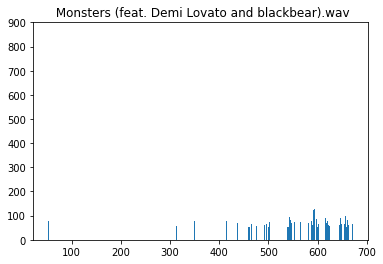

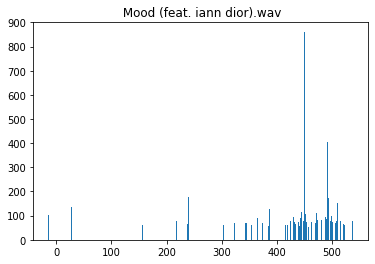

In [73]:
scores = {}
song_ids = [69, 0] # Song ID=0 is the true match
for song_id in song_ids:
    song_name = song_name_index[song_id].split('-')[1]

    matches = matches_per_song[song_id]
    print(f"Total matches for {song_name}: {len(matches)}")
    song_scores_by_offset = {}
    for hash, sample_time, source_time in matches:
        delta = source_time - sample_time
        if delta not in song_scores_by_offset:
            song_scores_by_offset[delta] = 0
        song_scores_by_offset[delta] += 1

    # Produce a histogram
    # For clarity's sake, only plot the 100 largest offsets
    high_scores = list(sorted(song_scores_by_offset.items(), key=lambda x: x[1], reverse=True))[:100]
    plt.figure()
    plt.bar(*zip(*high_scores))
    plt.title(song_name)
    plt.ylim((0, 900))

See how the total matches for Monsters is actually *higher* than the true match, Mood? However, there is a significant spike at a time index of ~430 for Mood, however, there is no spike even close in height for Monsters!

This clearly indicates that Mood is a much better match than Monsters. This method to find a match can be extended to all songs, with each song being assigned a score based on the largest peak in it's histogram.

In [77]:
scores = {}
for song_index, matches in matches_per_song.items():
    song_scores_by_offset = {}
    for hash, sample_time, source_time in matches:
        delta = source_time - sample_time
        if delta not in song_scores_by_offset:
            song_scores_by_offset[delta] = 0
        song_scores_by_offset[delta] += 1

    max = (0, 0)
    for offset, score in song_scores_by_offset.items():
        if score > max[1]:
            max = (offset, score)
    
    scores[song_index] = max

for song_index, score in list(sorted(scores.items(), key=lambda x: x[1][1], reverse=True))[:5]:
    print(f"{song_name_index[song_index]}: Score of {score[1]} at {score[0]}")

data/001. 24kgoldn - Mood (feat. iann dior).wav: Score of 912 at 239
data/068. Thomas Rhett - What’s Your Country Song.wav: Score of 201 at 611
data/081. Morgan Wallen - Somebody’s Problem.wav: Score of 191 at 516
data/064. Darius Rucker - Beers And Sunshine.wav: Score of 181 at 642
data/056. Yung Bleu - You’re Mines Still (feat. Drake).wav: Score of 165 at 789


The final total method to find a match is below:

In [80]:
def score_hashes_against_database(hashes):
    matches_per_song = {}
    for hash, (sample_time, _) in hashes.items():
        if hash in database:
            matching_occurences = database[hash]
            for source_time, song_index in matching_occurences:
                if song_index not in matches_per_song:
                    matches_per_song[song_index] = []
                matches_per_song[song_index].append((hash, sample_time, source_time))
            

    # %%
    scores = {}
    for song_index, matches in matches_per_song.items():
        song_scores_by_offset = {}
        for hash, sample_time, source_time in matches:
            delta = source_time - sample_time
            if delta not in song_scores_by_offset:
                song_scores_by_offset[delta] = 0
            song_scores_by_offset[delta] += 1

        max = (0, 0)
        for offset, score in song_scores_by_offset.items():
            if score > max[1]:
                max = (offset, score)
        
        scores[song_index] = max

    # Sort the scores for the user
    scores = list(sorted(scores.items(), key=lambda x: x[1][1], reverse=True)) 
    
    return scores

We can test our new scoring with two audio recordings. The first is a relatively pristine recording taken with my phone, the second includes background conversation from a news broadcast. Unsurprisingly, both are matched equally well! 

In [92]:
def print_top_five(file_name):
    # Load a short recording with some background noise
    Fs, audio_input = read(file_name)
    # Create the constellation and hashes
    constellation = create_constellation(audio_input, Fs)
    hashes = create_hashes(constellation, None)

    scores = score_hashes_against_database(hashes)[:5]
    for song_id, score in scores:
        print(f"{song_name_index[song_id]}: Score of {score[1]} at {score[0]}")

print("Recording 1:")
print_top_five("recording1.wav")

print("\n\nRecording 2:")
print_top_five("recording2.wav")

Recording 1:
data/001. 24kgoldn - Mood (feat. iann dior).wav: Score of 869 at 139
data/048. Niko Moon - GOOD TIME.wav: Score of 170 at 778
data/056. Yung Bleu - You’re Mines Still (feat. Drake).wav: Score of 168 at 840
data/050. Russell Dickerson - Love You Like I Used To.wav: Score of 168 at 646
data/094. Eric Church - Hell Of A View.wav: Score of 166 at 609


Recording 2:
data/001. 24kgoldn - Mood (feat. iann dior).wav: Score of 912 at 239
data/068. Thomas Rhett - What’s Your Country Song.wav: Score of 201 at 611
data/081. Morgan Wallen - Somebody’s Problem.wav: Score of 191 at 516
data/064. Darius Rucker - Beers And Sunshine.wav: Score of 181 at 642
data/056. Yung Bleu - You’re Mines Still (feat. Drake).wav: Score of 165 at 789


# Conclusion
This article has covered the fundamentals of Shazam from start to finish - including an introduction to Fourier analysis. 

There are countless improvements that I'm sure could be made to improve the time and storage requirements at various steps, and doubtless improvements could be made to the Fourier analysis to work better in a wider variety of environments - but this implementation still fundamentally works.